#**Developing an Artificially Intelligent Wine Critic (Notebook)**

By Ben Thompson-Watson

# **1. Data Collection**

## 1.1. Installing Dependencies

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import (cross_val_score, GridSearchCV, train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import (LinearSVC, SVC)
from math import sqrt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.svm import SVR

## 1.2. Dataset Installation

- The datasets are downloaded from my public github repository

- If you do not want to use my github links for the datasets please ensure that both the datasets 'winequality-red.csv' and 'winequality-white.csv' are uploaded to the root folder of this notebook.

- Otherwise please change the filepaths for the datasets in the read functions below.

In [ ]:
# Download datasets from my github, or change links to paths of local copies of the datasets
df_red_original = pd.read_csv('https://raw.githubusercontent.com/BenWatson2000/data_science_storage/main/winequality-red.csv', header=0, delimiter=";")
df_white_original = pd.read_csv('https://raw.githubusercontent.com/BenWatson2000/data_science_storage/main/winequality-white.csv', header=0, delimiter=";")

df_red = df_red_original
df_white = df_white_original

#Set variable which identifies the colour of the wine (1 being red, 0 being white)
df_red['key'] = '1';
df_white['key'] = '0';

#Feature that we are predicting
pred_feat = 'quality' 

# **2. Data Preperation and Visualisation**

## 2.1. Colour Pallete definition and first instance of concatenated dataset.

- Using red for red wine and green for white wine (green stands out better on graphs).

- Concatenated dataset has seperated red wine and white wine using the 'key' attribute.

In [ ]:
palette = {'1':"red",'0':"green"}
concat_df = pd.concat([df_red,df_white])

## 2.2. Frequency of Records in each dataset

- There are far more white wine than red wine records, therefore when plotting distributions and comparing the two types, i must ensure the data is normalised.

In [ ]:
print("Frequency of records in each dataset \n-------------------------------------")
print("There are {} red wine records.".format(len(df_red)))
print("There are {} white wine records.".format(len(df_white)))
print("-------------------------------------")

Frequency of records in each dataset 
-------------------------------------
There are 1599 red wine records.
There are 4898 white wine records.
-------------------------------------


## 2.3. Attribute frequency analysis

- Report below will print out the frequency and attributes if there are less than 10, otherwise just the frequency.

- I knew most of these attributes would be continous however i wanted to see how sparse the data was for certain attributes and if it would help to change any continuous data into catergorical.


In [ ]:
# Investigate all the elements whithin each Feature 
print("Frequency of values for each attribute \n----------------------------------------")

for column in concat_df:
  all_pos = np.unique(concat_df[column])
  freq = len(all_pos)
  if freq < 10:
    print("{} : {} -- {}".format(column, all_pos, freq))
  else:
    print("{} : {} ".format(column, freq))

print("----------------------------------------")

Frequency of values for each attribute 
----------------------------------------
fixed acidity : 106 
volatile acidity : 187 
citric acid : 89 
residual sugar : 316 
chlorides : 214 
free sulfur dioxide : 135 
total sulfur dioxide : 276 
density : 998 
pH : 108 
sulphates : 111 
alcohol : 111 
quality : [3 4 5 6 7 8 9] -- 7
key : ['0' '1'] -- 2
----------------------------------------


## 2.4. Histogram Plot Illustrating distribution between both red and white wine

- To take into account the unblanced dataset (more white wine than red wine records) I used the `common_norm=False` attribute. 

- From this plot i noticed three things:

  1. Red wine typically seemed to have more wines that were lower quality that white wines.

  2. The quality attribute for wines was unbalanced with higher frequencies in 6 and 5, which will result in the machine learning model finding it difficult to predict wines with a quality of 3 or 9. 

  3. The quality for wine in this dataset started from 3 instead of 0, therefore it would be impossible to predict a wine under the quality rating 3.

Text(0.5, 1.0, "Distribution of 'quality' for Red and White wine")

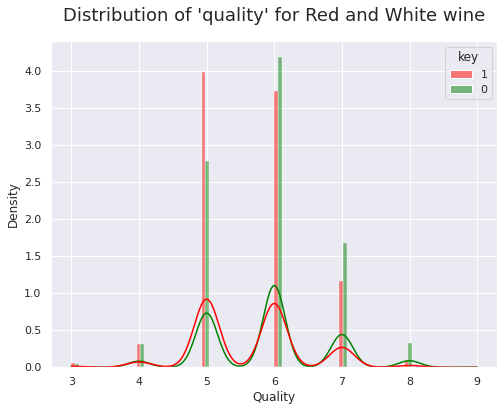

In [ ]:
# Plot for quality distribution
sns.set(rc={'figure.figsize':(8,6)})
compare_box = sns.histplot(data=concat_df,x=concat_df['quality'],hue="key",palette=palette,common_norm=False,stat='density',multiple='dodge',kde=True)
compare_box.set_xlabel('Quality')
compare_box.set_ylabel("Density")
compare_box.set_title("Distribution of 'quality' for Red and White wine",fontsize=18,pad=20)

## 2.5. Count Plot of Quality Frequency

- To help better illustrate this finding, I gave provided a count plot which annotates the percent each quality level appears in the dataset.

- Below is also a frequency report, showing that for quality level 9 there are only records.


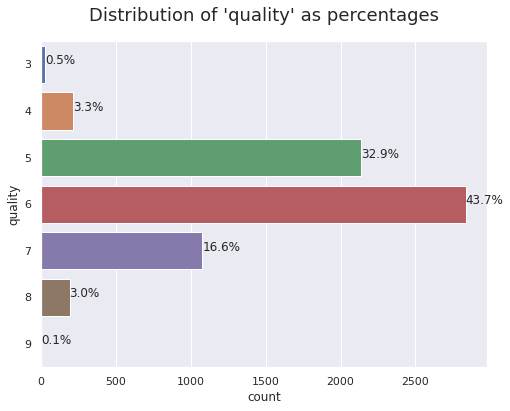

Frequency of records per quality level 
----------------------------------------
Quality level 3 : 30
Quality level 4 : 216
Quality level 5 : 2138
Quality level 6 : 2836
Quality level 7 : 1079
Quality level 8 : 193
Quality level 9 : 5
----------------------------------------


In [ ]:
# Create a dictionary of the frequency of each quality label.
r = concat_df['quality'].value_counts().to_dict()

# Create a countplot for the quality values
ax = sns.countplot(data=concat_df,y='quality')
ax.set_title("Distribution of 'quality' as percentages",fontsize=18,pad=20)
total = sum(r.values())

# Add percentage labels to plot
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width  ()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + (p.get_height()/ 2)
        ax.annotate(percentage, (x, y))
plt.show()

# Report frequencies from the dictionary.
sorted_keys = sorted(r)
print("Frequency of records per quality level \n----------------------------------------")
for k in sorted_keys:
  freq = r[k]
  print("Quality level {} : {}".format(k, freq))
print("----------------------------------------")

## 2.6. Distributions of each attribute for red and white wine.

- I wanted to compare both red and white wine for each attribute to see if there were any notable differences between the types, i.e. sweetness being higher in white wines etc.

Some notable findings were:

- Red wine is on average slightly more acidic than white wine.

- White wine is on average sweeter than red wine.

- Chloride levels were on average higher in red wine.

- Red wine on average is more dense than white wine.

- White wine on average was of higher quality than red wine.


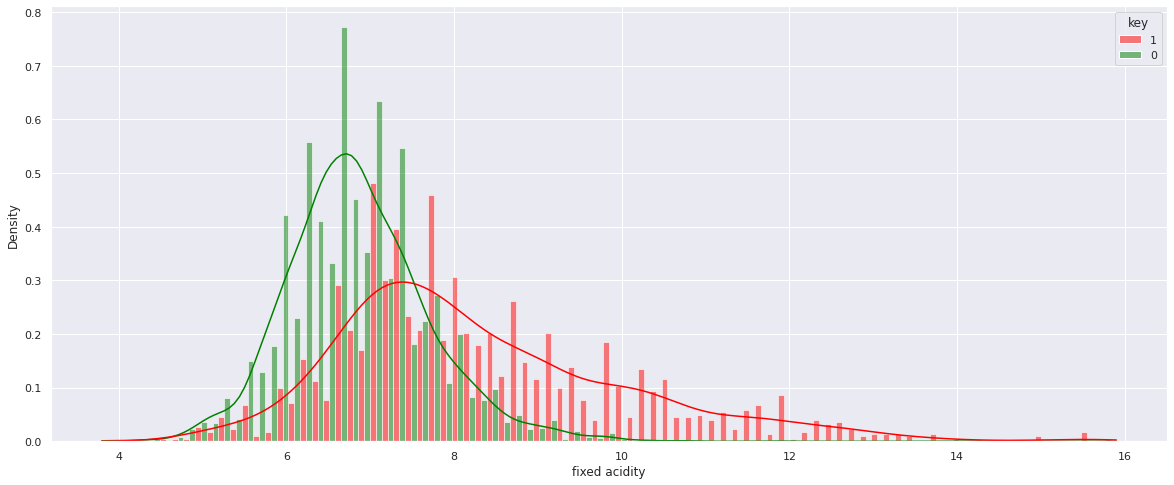

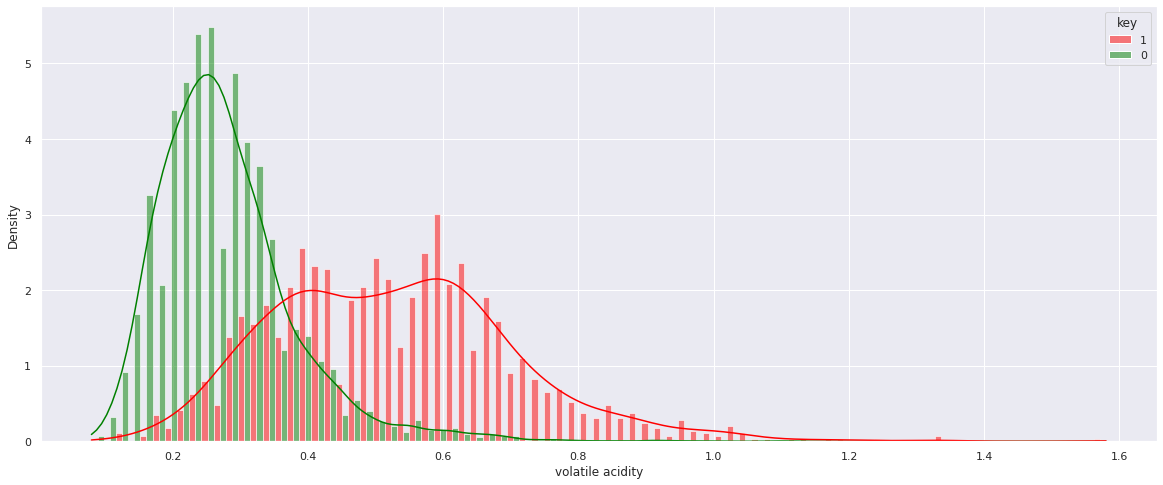

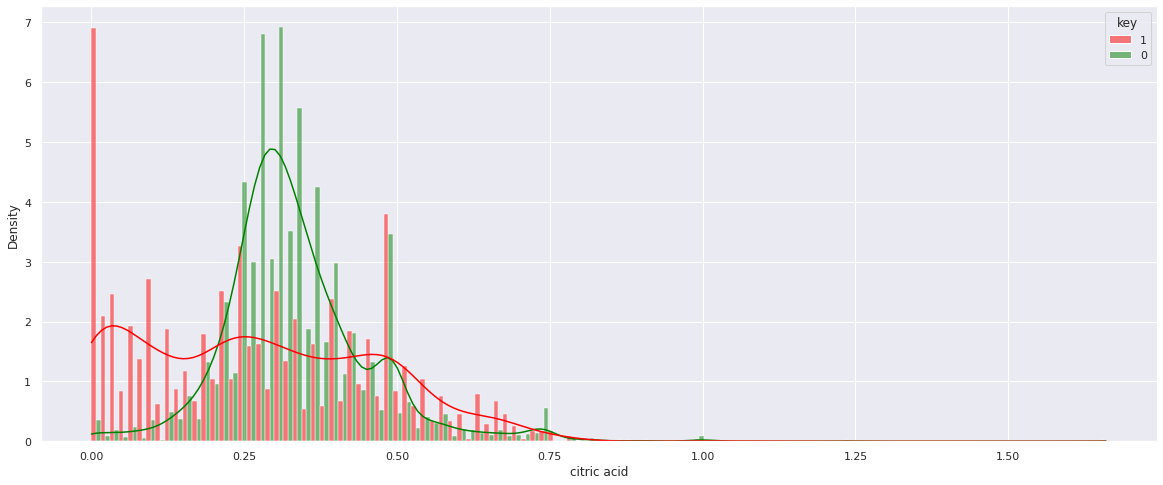

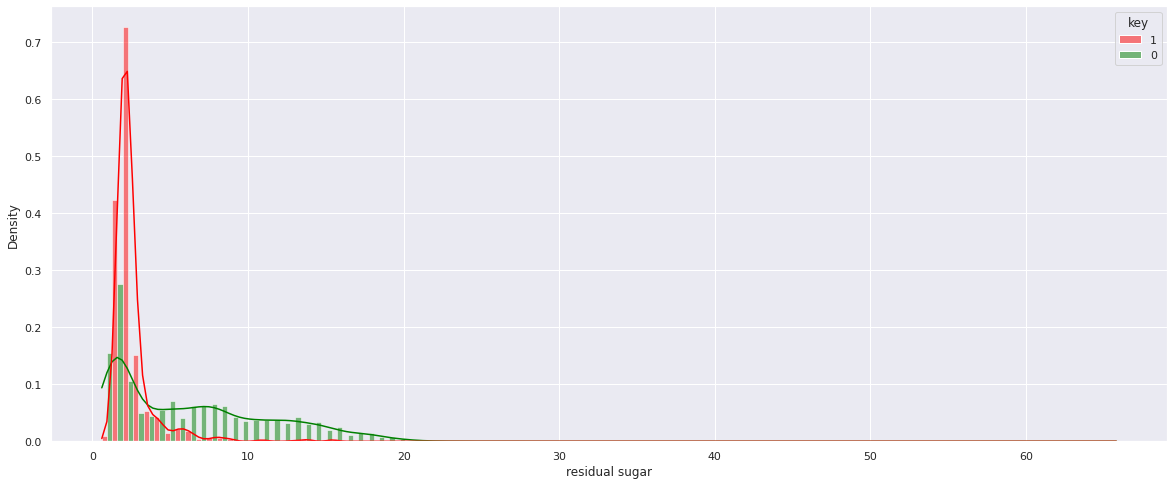

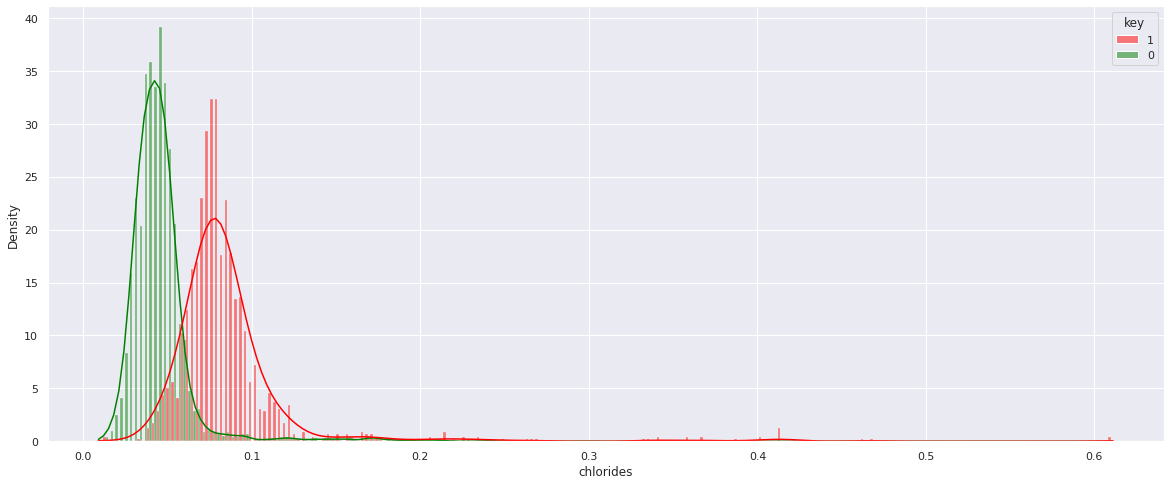

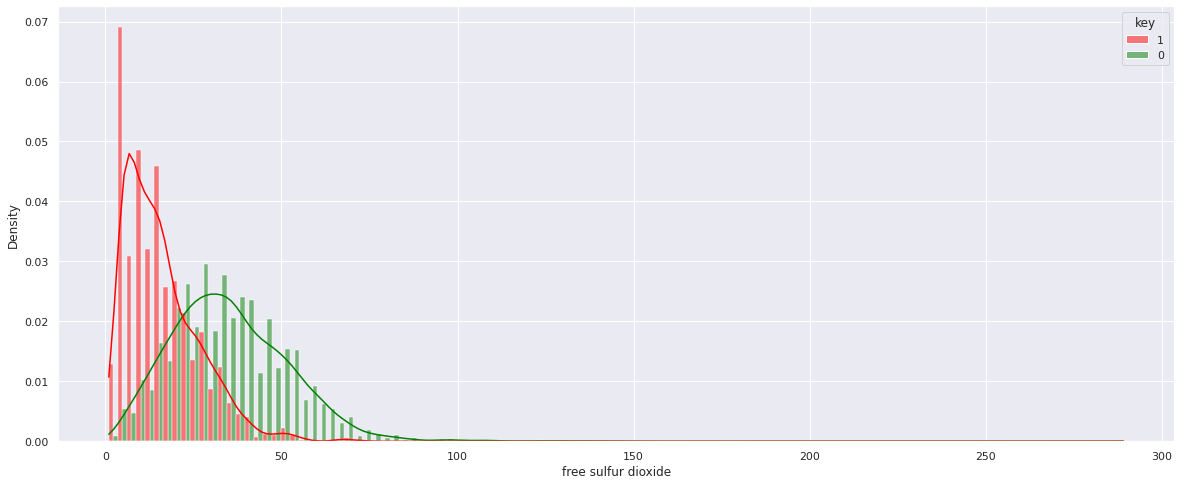

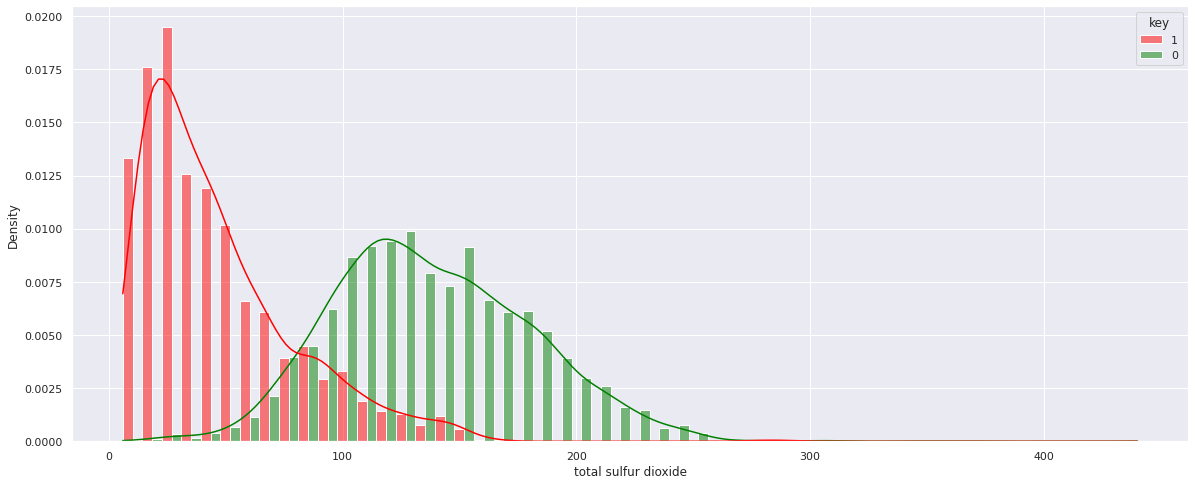

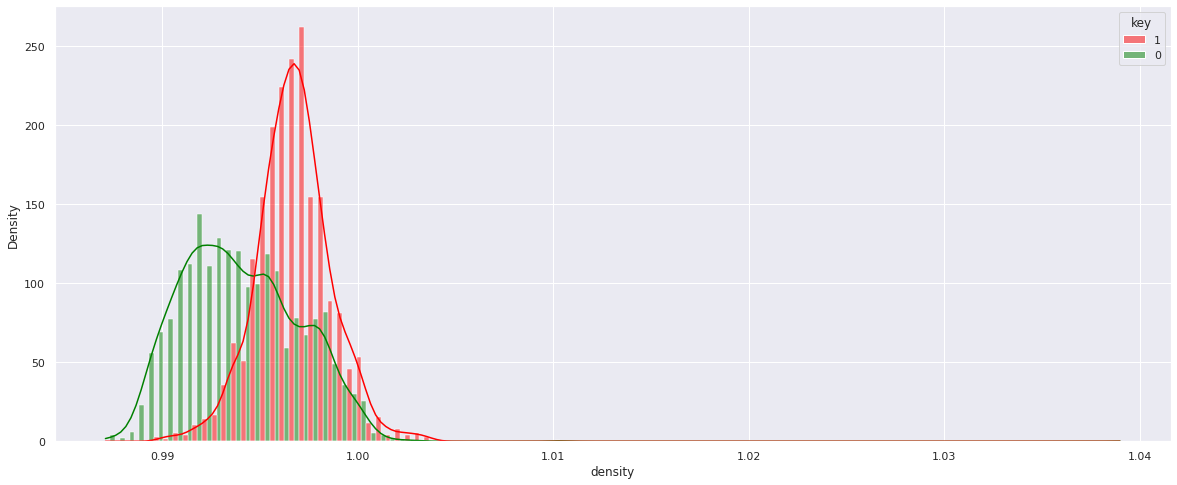

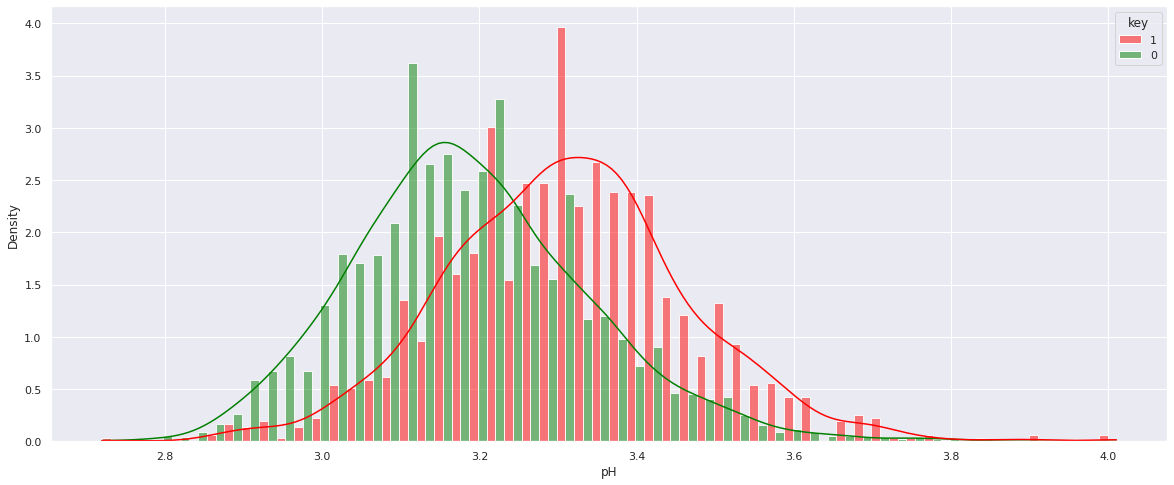

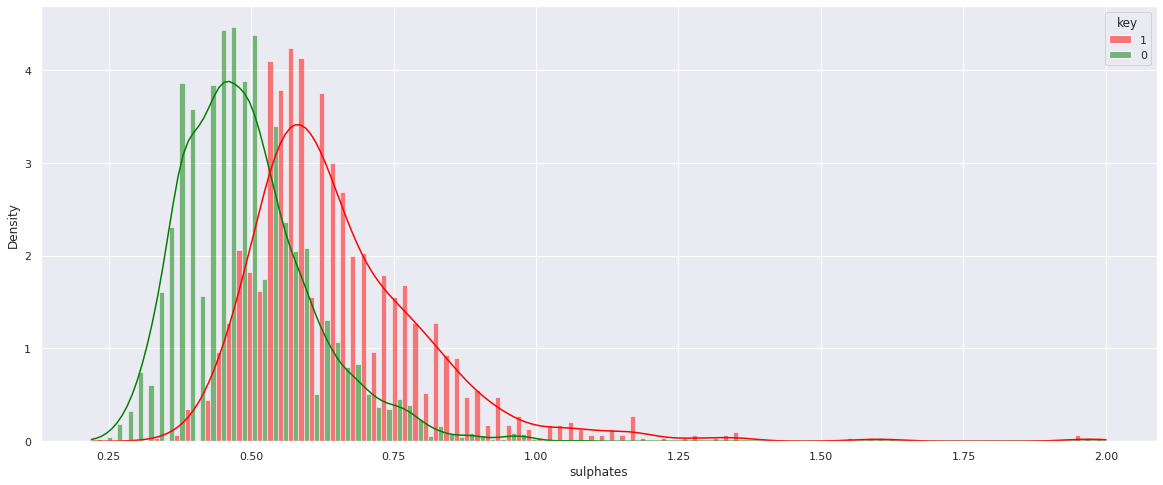

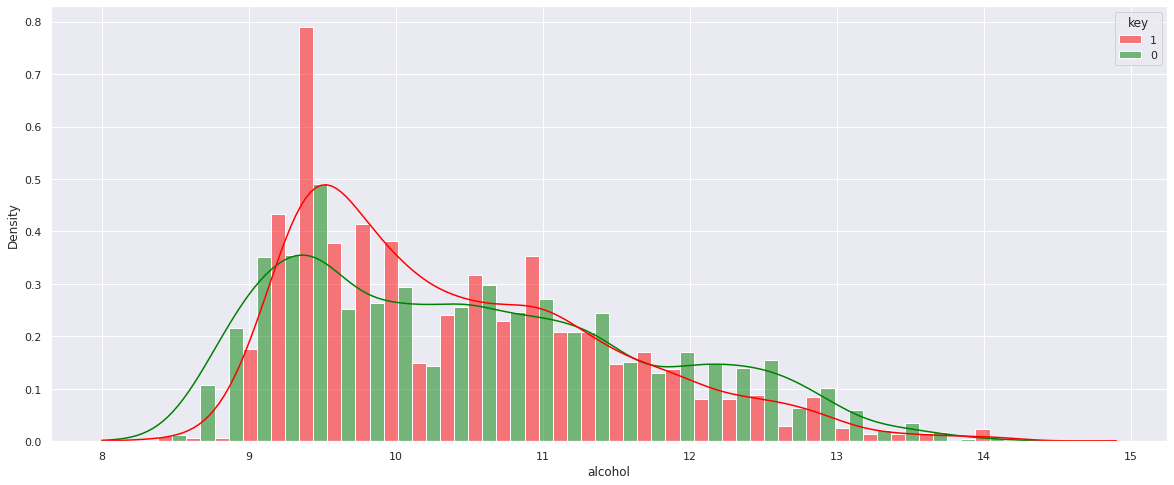

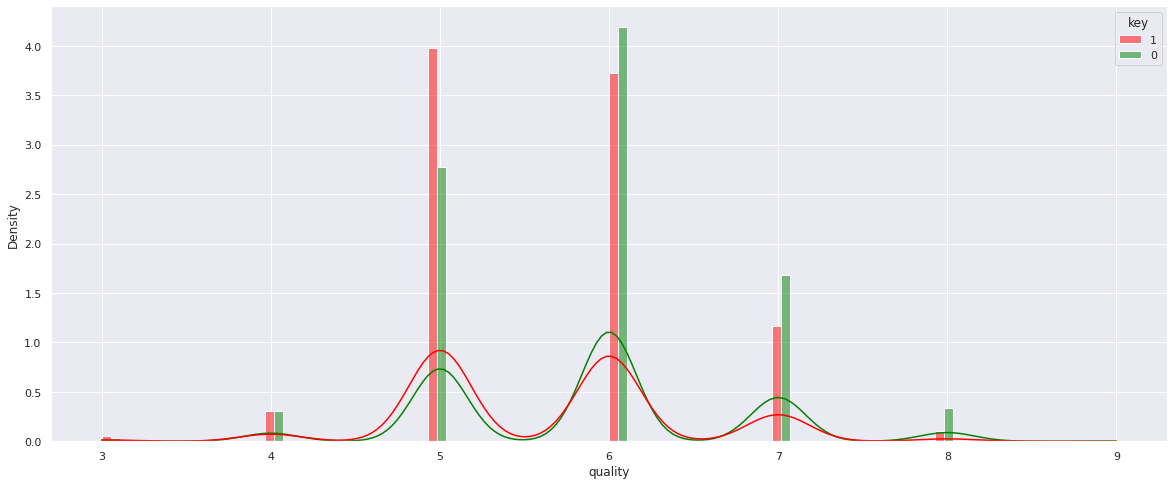

In [ ]:
# Distributions of each feature in both the red and white wine datasets

numerical = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']

for i in range(len(numerical)):
  dims = (20, 8)
  fig, ax = plt.subplots(1,1,figsize=dims)  
  sns.histplot(concat_df,x=concat_df[numerical[i]], color='blue',hue='key',palette=palette,common_norm=False,stat='density',ax=ax,multiple='dodge',kde=True)

## 2.7. Outlier Removal Phase

- The attributes 'alcohol', and 'quality' did not have any applicable attributes.

In [ ]:
# Outlier removal for red wine
df_red_removed = df_red[(df_red['fixed acidity'] <= 14) &
                        (df_red['fixed acidity'] >= 4) &
                        (df_red['volatile acidity'] <= 1.05) &
                        (df_red['citric acid'] <= 0.8) &
                        (df_red['residual sugar'] <= 10) &
                        (df_red['chlorides'] <= 0.15) &
                        (df_red['free sulfur dioxide'] <= 75) &
                        (df_red['total sulfur dioxide'] <= 200) &
                        (df_red['density'] <= 1.005) & 
                        (df_red['pH'] <= 3.8) &
                        (df_red['pH'] >= 2.8) &
                        (df_red['sulphates'] <= 1.25) &
                        (df_red['sulphates'] >= 0.25)]

# Outlier removal for white wine
df_white_removed = df_white[(df_white['fixed acidity'] <= 10) &
                        (df_white['fixed acidity'] >= 4) &
                        (df_white['volatile acidity'] <= 0.7) &
                        (df_white['citric acid'] <= 0.8) &
                        (df_white['residual sugar'] <= 20) &
                        (df_white['chlorides'] <= 0.1) &
                        (df_white['free sulfur dioxide'] <= 80) &
                        (df_white['total sulfur dioxide'] <= 275) &
                        (df_white['density'] <= 1.005) & 
                        (df_white['pH'] <= 3.7) &
                        (df_white['pH'] >= 2.8) &
                        (df_white['sulphates'] <= 1.0) &
                        (df_white['sulphates'] >= 0.25)]

# The concatenation of both wines with removed outliers                              
removed_outliers = pd.concat([df_red_removed,df_white_removed])

# Report of removal
print("Outlier Removal Report \n----------------------------------------")

print("Shape of original: {}".format(concat_df.shape))
print("Shape of removed: {}".format(removed_outliers.shape))

disregarded_records = pd.concat([concat_df, removed_outliers]).drop_duplicates(keep=False)

print("Number of removed outliers: {}".format(len(disregarded_records)))

print("----------------------------------------")

Outlier Removal Report 
----------------------------------------
Shape of original: (6497, 13)
Shape of removed: (6151, 13)
Number of removed outliers: 269
----------------------------------------


## 2.8. A look back at the distributions after the outliers removal

- This has removed any heave head or tail distributions on the graphs, making them easier to interpret.

- Now the outliers are removed, the machine learning algorithm will be more accurate when predicting the quality.

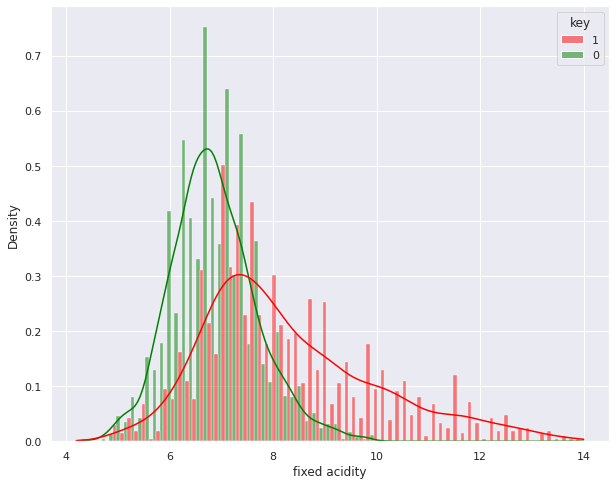

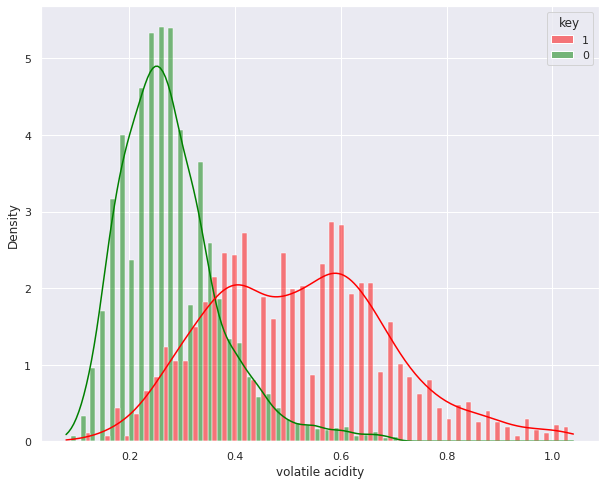

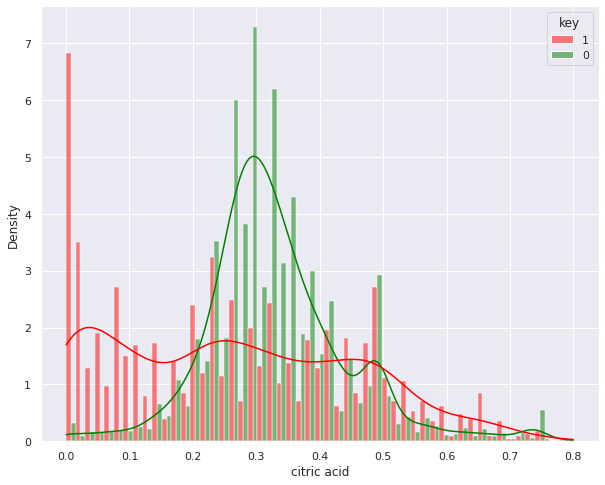

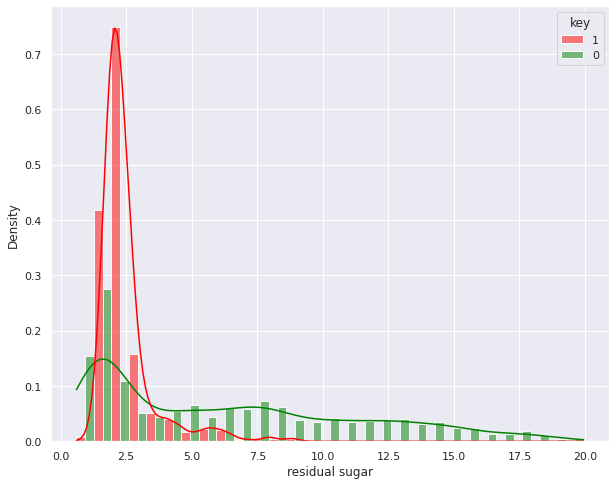

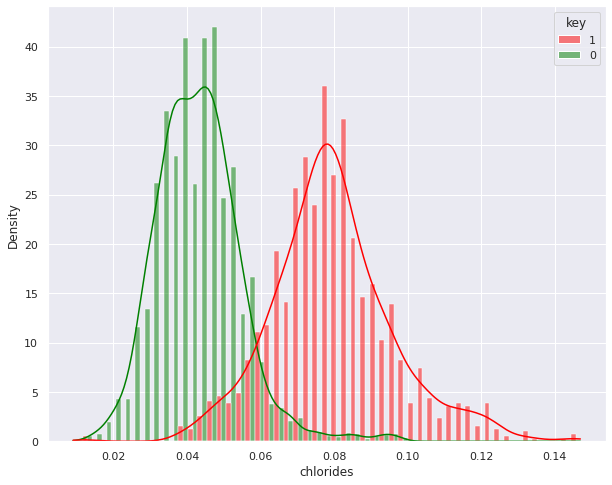

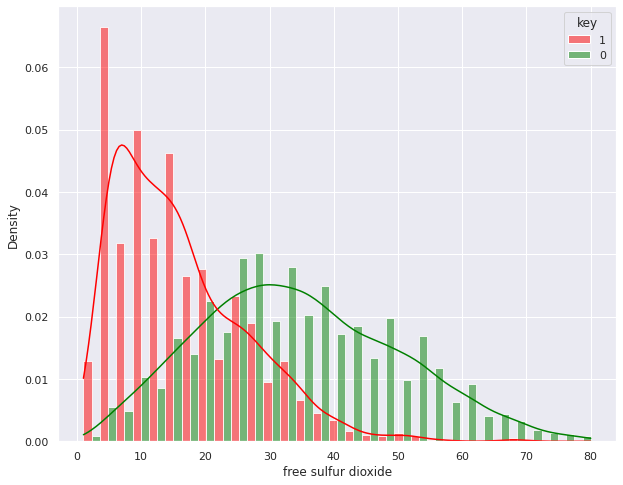

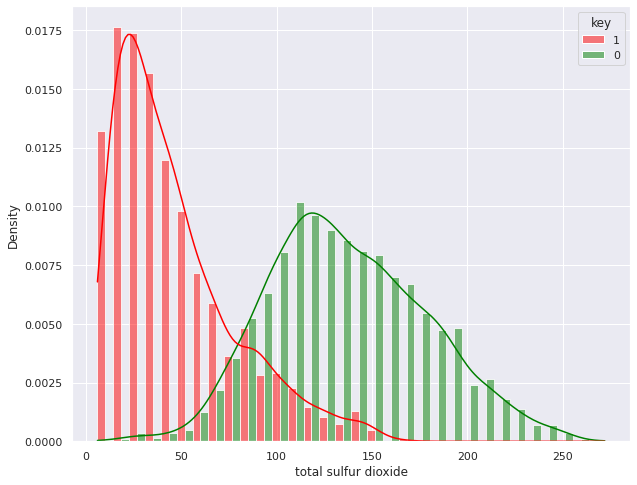

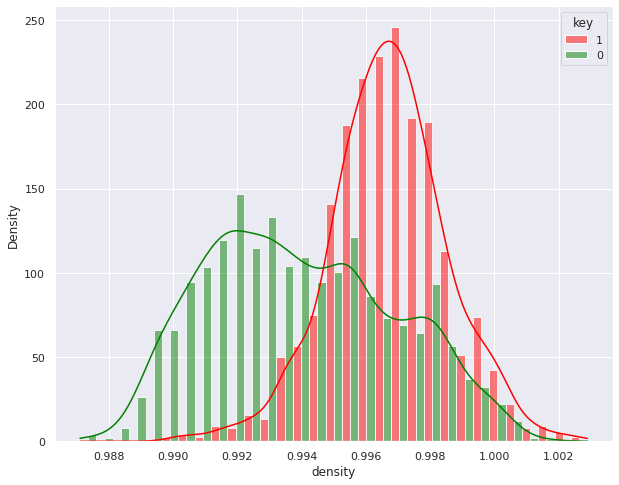

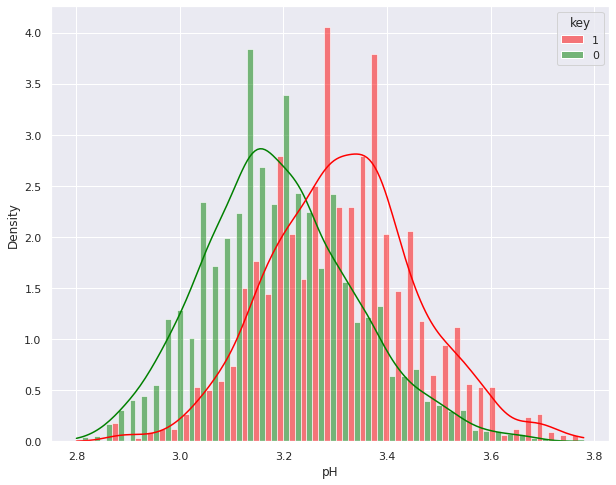

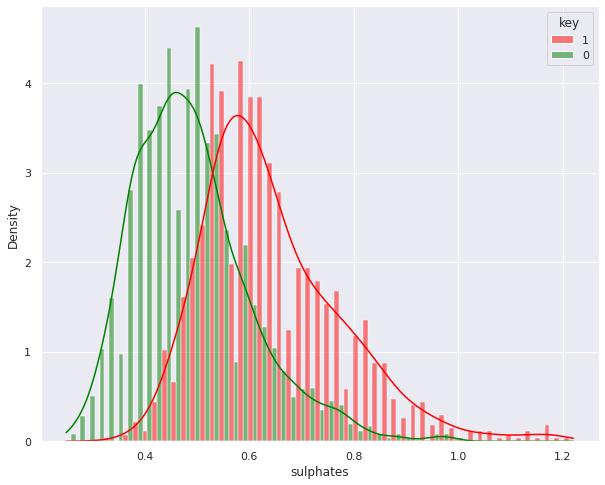

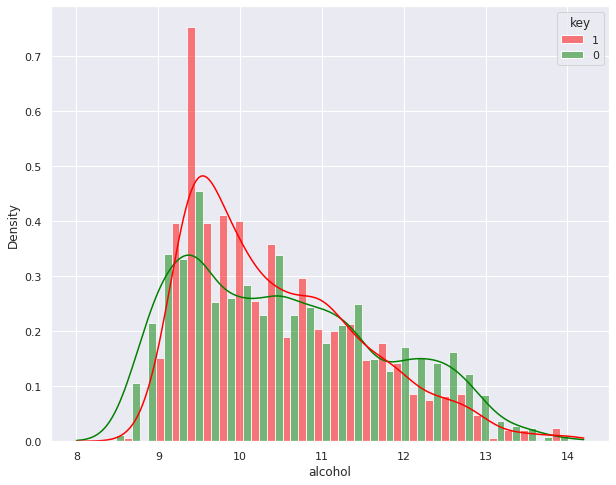

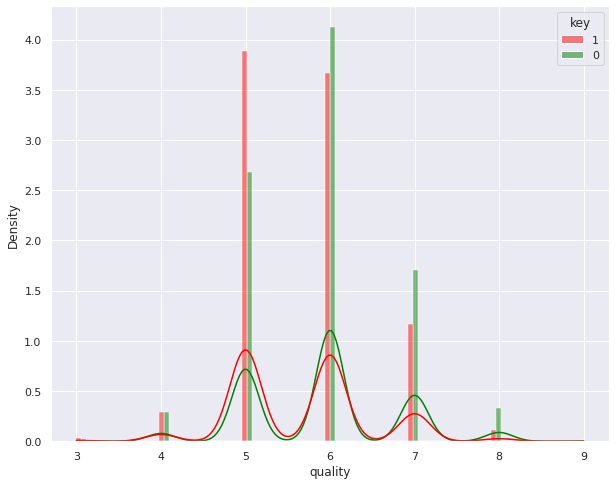

In [ ]:
#Updated distributions of red and white wine features after outlier removal

for i in range(len(numerical)):
  dims = (10, 8)
  fig, ax = plt.subplots(1,1,figsize=dims)  
  sns.histplot(removed_outliers,x=removed_outliers[numerical[i]], color='blue',hue='key',palette=palette,common_norm=False,stat='density',ax=ax,multiple='dodge',kde=True) 

# **3. Changing continuous data to catergorical data**

## 3.1. Alcohol Level Catergorisation

-  From the frequency analysis in section 2.3, there are 111 different values that are used for this attribute.

- To make it simpler, I have mapped these values to one of three catergories 'low', 'mid' and 'high'.

- Because I am dealing with red and white wine, I decided to seperate them into their own data frames when calculating the means and standard deviations so that the catergories are relative to their wine type.

In [ ]:
# White wine statistical information creation (mean and stdev)
new_df_white = df_white_removed
white_data_struct = df_white_removed[numerical].describe()
white_alc_mean = white_data_struct['alcohol']['mean']
white_alc_stddev = white_data_struct['alcohol']['std']

# Red wine statistical information creation (mean and stdev)
new_df_red = df_red_removed
red_data_struct = df_white_removed[numerical].describe()
red_alc_mean = red_data_struct['alcohol']['mean']
red_alc_stddev = red_data_struct['alcohol']['std']

# Make all alcohol_cat values blank for white wine
new_df_white['alcohol_cat'] = ''
for record in new_df_white.index:

  # Use alcohol value and compare with mean and stdev to decide its catergory
  x = new_df_white['alcohol'][record]
  if (x < white_alc_mean - white_alc_stddev):
    new_df_white['alcohol_cat'][record] = 'low'
  elif (x > white_alc_mean + white_alc_stddev):
    new_df_white['alcohol_cat'][record] = 'high'
  else:
    new_df_white['alcohol_cat'][record] = 'mid'

# Make all alcohol_cat values blank for red wine
new_df_red['alcohol_cat'] = ''
for record in new_df_red.index:

  # Use alcohol value and compare with mean and stdev to decide its catergory
  x = new_df_red['alcohol'][record]
  if (x < red_alc_mean - red_alc_stddev):
    new_df_red['alcohol_cat'][record] = 'low'
  elif (x > red_alc_mean + red_alc_stddev):
    new_df_red['alcohol_cat'][record] = 'high'
  else:
    new_df_red['alcohol_cat'][record] = 'mid'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, s

## 3.2. Visualisation of new alcohol catergorisation

- Below are two graphs (one for red wine the other for white wine)

- Plotted is the density against quality.

- Both wine types show similar trends and support the case that the higher the alcohol level, the higher the quality of wine.

Text(0.5, 1.0, 'White Wine')

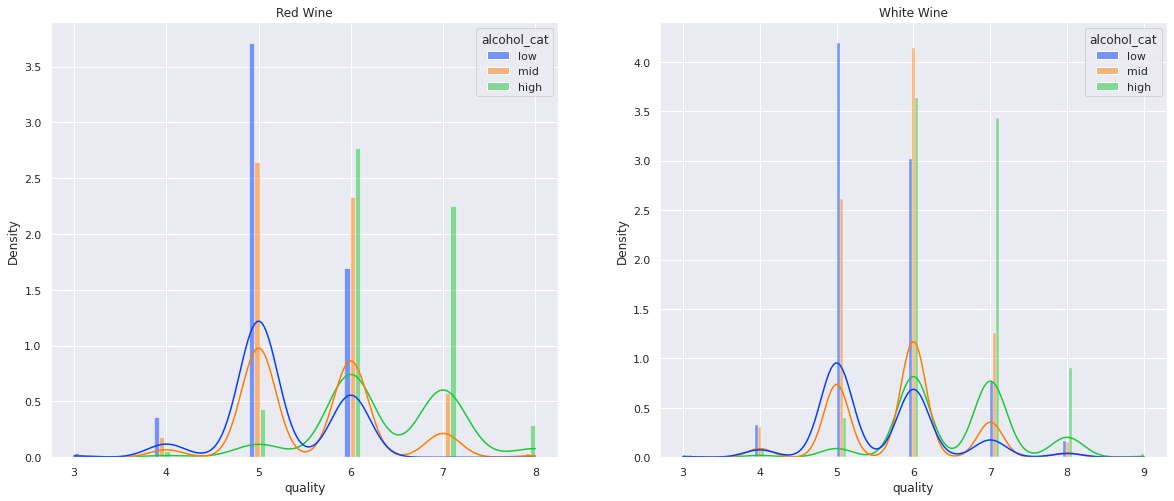

In [ ]:
dims = (20, 8)
fig, ax = plt.subplots(1,2,figsize=dims)
order = ['low','mid','high']
sns.histplot(new_df_red,x='quality',hue='alcohol_cat',ax=ax[0],kde=True,palette='bright',hue_order=order, multiple="dodge",stat='density',common_norm=False).set_title("Red Wine")
sns.histplot(new_df_white,x='quality',hue='alcohol_cat',ax=ax[1],kde=True,palette='bright',hue_order=order, multiple="dodge",stat='density',common_norm=False).set_title("White Wine")

## 3.3. Boxen Plot Visualisation of Alcohol Catergorisation

- This clearly shows that for wines in the 'high' level catergory they are typically getting a quality of 6+

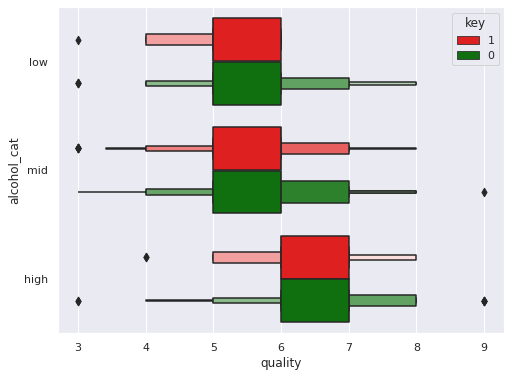

In [ ]:
sns.boxenplot(data=pd.concat([new_df_red,new_df_white]),x='quality',y='alcohol_cat',hue='key',palette=palette,order=['low','mid','high'])

## 3.4. Residual Sugar Catergorisation

- Actual threshold for a sweet wine is 20, however after trying this on the dataset, it does not split the wine very evenly.

- White wine and Red wine typically have differences in terms of sweetness, which made me think that maybe it would be important to split the sugar residue using different thresholds for each wine type.

- I will be testing the concantenated dataset as a model too therefore i have included its own threshold too.

In [ ]:
# Different isSweet thresholds which equally split the distribution in half.
threshold_concat = 3.5
threshold_red = 2.19
threshold_white = 5

# Dataset declaration from previous results
sugar_concat_df = pd.concat([new_df_red,new_df_white])
sugar_red_df = sugar_concat_df[(sugar_concat_df['key'] == '1')]
sugar_white_df = sugar_concat_df[(sugar_concat_df['key'] == '0')]

# Creating the isSweet values by using 'bins' over the residual sugar values.
sugar_concat_df['isSweet'] = sugar_concat_df['residual sugar']
sugar_concat_df['isSweet'] = pd.cut(sugar_concat_df['isSweet'],bins=[0.0,threshold_concat,100000.0],labels=[0,1]).astype('int64')

sugar_red_df['isSweet'] = sugar_red_df['residual sugar']
sugar_red_df['isSweet'] = pd.cut(sugar_red_df['isSweet'],bins=[0.0,threshold_red,100000.0],labels=[0,1]).astype('int64')

sugar_white_df['isSweet'] = sugar_white_df['residual sugar']
sugar_white_df['isSweet'] = pd.cut(sugar_white_df['isSweet'],bins=[0.0,threshold_white,100000.0],labels=[0,1]).astype('int64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

## 3.5. Visualisation of new residual sugar catergorisation

- You can see the distribution of the residual sugar and how it changes to sweet (1) after residual sugar level 12.

Class Counts Report for attribute 'isSweet' 
---------------------------------------------------------
Concatenated 'isSweet' class counts: {0: 3251, 1: 2900}
Red 'isSweet' class counts:          {1: 797, 0: 697}
White 'isSweet' class counts:        {1: 2373, 0: 2284}
---------------------------------------------------------


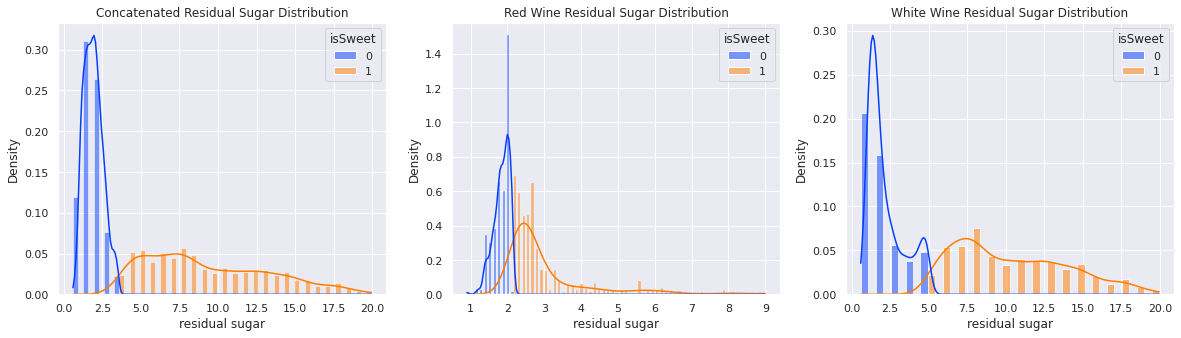

In [ ]:
dims = (20, 5)
fig, ax = plt.subplots(1,3,figsize=dims)

# Create histogram, showing the distribution of residual sugar, split by the 'isSweet' values
sns.histplot(data=sugar_concat_df,x='residual sugar',kde=True,palette='bright', 
             multiple="dodge",hue='isSweet',stat='density',ax=ax[0]).set_title("Concatenated Residual Sugar Distribution")
sns.histplot(data=sugar_red_df,x='residual sugar',kde=True,palette='bright', 
             multiple="dodge",hue='isSweet',stat='density',ax=ax[1]).set_title("Red Wine Residual Sugar Distribution")
sns.histplot(data=sugar_white_df,x='residual sugar',kde=True,palette='bright', 
             multiple="dodge",hue='isSweet',stat='density',ax=ax[2]).set_title("White Wine Residual Sugar Distribution")

# Create a dictionary showing the count of sweet to non sweet values for each dataset.
counts_concat = sugar_concat_df['isSweet'].value_counts().to_dict()
counts_red = sugar_red_df['isSweet'].value_counts().to_dict()
counts_white = sugar_white_df['isSweet'].value_counts().to_dict()

# Report counts calculated
print("Class Counts Report for attribute 'isSweet' \n---------------------------------------------------------")
print("Concatenated 'isSweet' class counts: {}".format(counts_concat))
print("Red 'isSweet' class counts:          {}".format(counts_red))
print("White 'isSweet' class counts:        {}".format(counts_white))
print("---------------------------------------------------------")

## 3.6. Sugar Residue Analysis Conclusion

- After comparing the analysis on the wines, it is clear that white wine is sweeter than red wine.

- There also appears to be no significant correlation between the isSweet variable and quality.



Text(0.5, 1.0, 'White Wine Dataset')

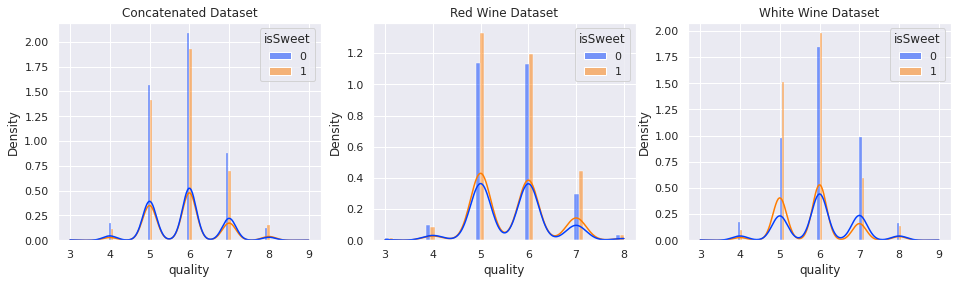

In [ ]:
# Plot each dataset, comparing the isSweet values with the quality distribution.
dims = (16, 4)
fig, ax = plt.subplots(1,3,figsize=dims)

sns.histplot(data=sugar_concat_df,x='quality',hue='isSweet',ax=ax[0],stat='density',multiple='dodge',palette='bright',kde=True).set_title("Concatenated Dataset")
sns.histplot(data=sugar_red_df,x='quality',hue='isSweet',ax=ax[1],stat='density',multiple='dodge',palette='bright',kde=True).set_title("Red Wine Dataset")
sns.histplot(data=sugar_white_df,x='quality',hue='isSweet',ax=ax[2],stat='density',multiple='dodge',palette='bright',kde=True).set_title("White Wine Dataset")

# **4. Correlation Analysis**

- Below is my analysis of all the attributes.

- I have used heat maps to spot correlations and a decision tree to state the feature importance of each variable.

- This will help me in my feature importance stage.


## 4.1. Turning 'alcohol_cat' into a numerical attribute

- Currently 'alcohol_cat' is a catergorical data type and if this was passed into the '.corr()' it would be completly ignored as it only handles numerical values.

- To get around this I used the build in panda function '.get_dummies()' which turns each catergory into its own variable and sets its value either a 0 or 1 depending on if that record was in that catergory.

- Also dropping the 'key' feature as it is no longer needed.

In [ ]:
# Use .get_dummies() to turn 'alcohol_cat' into a numerical atribute.
corr_red_df = (pd.get_dummies(sugar_red_df, columns=['alcohol_cat'])).drop('key',axis=1)
corr_white_df = (pd.get_dummies(sugar_white_df, columns=['alcohol_cat'])).drop('key',axis=1)
corr_concat_df = (pd.get_dummies(sugar_concat_df, columns=['alcohol_cat'])).drop('key',axis=1)

## 4.2. Correlation Calculation

- This section uses the 'kendall' method to calculate the correlation.

- I have split the wine into their independent wine types so i can look at their own correlations and then i will look at the correlation as a whole in the concatenated dataframe.


In [ ]:
# Create correlation dataframes for all the datasets using the kendall metric.
pc_red = corr_red_df.corr(method="kendall")
pc_white = corr_white_df.corr(method="kendall")
pc_concat = corr_concat_df.corr(method='kendall')

## 4.3. Displaying correlation results

- I decided to display the correlation results on a heat map as it is very easy to read and spot strong correlations based on the color of the cell.

- Dark blue is a strong positive correlation
- Light Yellow is a strong negative correlation

Text(0.5, 1.0, 'White Wine Heatmap')

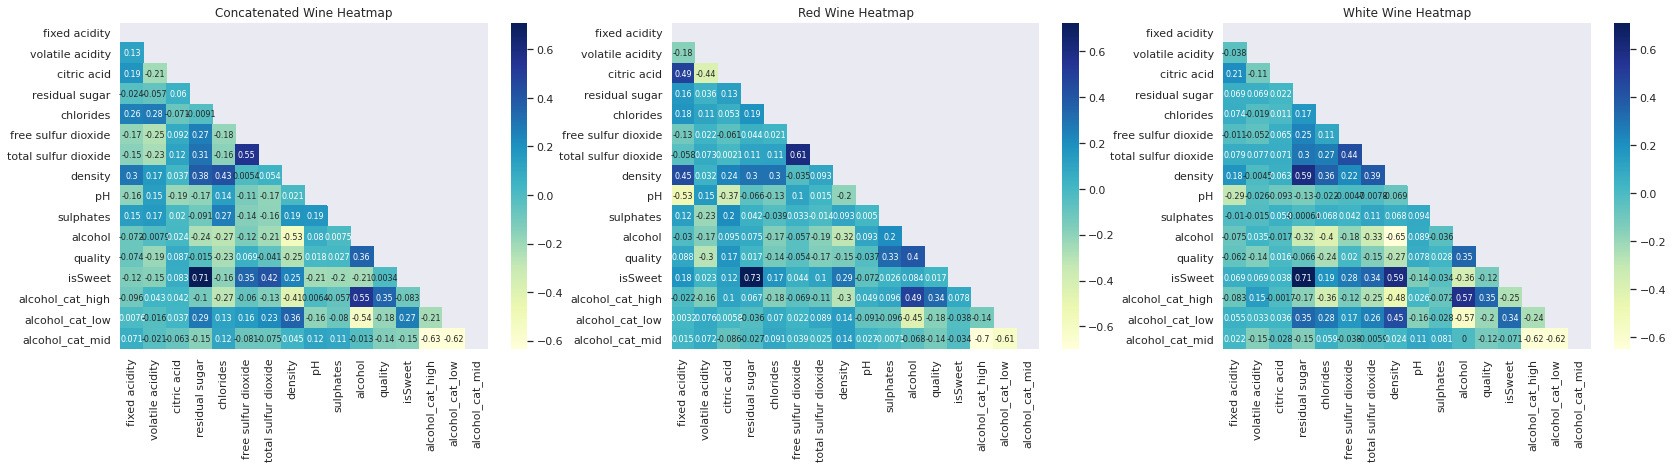

In [ ]:
# Create subplots to fit all 3 dataset heatmaps
dims = (28, 6)
fig, ax = plt.subplots(1,3,figsize=dims)

# Create heatmap for concatenated dataset
mask_concat = np.zeros_like(pc_concat)
mask_concat[np.triu_indices_from(mask_concat)] = True

hm_concat = sns.heatmap(pc_concat, 
                 annot = True,mask=mask_concat,cmap="YlGnBu", ax=ax[0], annot_kws={"size": 8})
hm_concat.set_title("Concatenated Wine Heatmap")

# Create heatmap for red wine dataset
mask_red = np.zeros_like(pc_red)
mask_red[np.triu_indices_from(mask_red)] = True
hm_red = sns.heatmap(pc_red, 
                 annot = True,mask=mask_red,cmap="YlGnBu", ax=ax[1], annot_kws={"size": 8})
hm_red.set_title("Red Wine Heatmap")

# Create heatmap for white wine dataset
mask_white = np.zeros_like(pc_white)
mask_white[np.triu_indices_from(mask_white)] = True
hm_white = sns.heatmap(pc_white, 
                 annot = True,mask=mask_white,cmap="YlGnBu", ax=ax[2], annot_kws={"size": 8})
hm_white.set_title("White Wine Heatmap")

From the above analysis using heatmaps I can conclude that it will be important to concider dropping the features:

**Concatenated Dataset**

- Density
- Free Suphur Dioxide
- Ph
- Sulphates


**Red Wine Dataset**

- Fixed Acidity
- Citric Acid
- Ph
- isSweet
- Residual Sugar


**White Wine Dataset**

- Density 
- Free Sulfur Dioxide
- Ph
- Sulphates
- Citric Acid

## 4.4. Variance Analysis

- Measuring the variance of each feature can be a useful approach to decide on which features to select for the machine learning process.

- This is because the train set may have values within a small range and the test set may have values in a large range, therefore will be predicted incorrectly, it is important to sometimes not use values with a small variance.



In [ ]:
# Calculate the variances for each dataset
statistics_concat = corr_concat_df.std() * corr_concat_df.std()
statistics_red = corr_red_df.std() * corr_red_df.std()
statistics_white = corr_white_df.std() * corr_white_df.std()

# Report the top 3 lowest variances for each dataset
print("Three of the lowest variances for features in concatenated dataset\n-------------------------------------------------------------------")
print(statistics_concat.nsmallest(3,keep='all'))
print("-------------------------------------------------------------------")
print()
print("Three of the lowest variances for features in red wine dataset\n-------------------------------------------------------------------")
print(statistics_red.nsmallest(3,keep='all'))
print("-------------------------------------------------------------------")
print()
print("Three of the lowest variances for features in white wine dataset\n-------------------------------------------------------------------")
print(statistics_white.nsmallest(3,keep='all'))
print("-------------------------------------------------------------------")

Three of the lowest variances for features in concatenated dataset
-------------------------------------------------------------------
density      0.000009
chlorides    0.000412
sulphates    0.018336
dtype: float64
-------------------------------------------------------------------

Three of the lowest variances for features in red wine dataset
-------------------------------------------------------------------
density      0.000003
chlorides    0.000277
sulphates    0.017984
dtype: float64
-------------------------------------------------------------------

Three of the lowest variances for features in white wine dataset
-------------------------------------------------------------------
density             0.000008
chlorides           0.000131
volatile acidity    0.008930
dtype: float64
-------------------------------------------------------------------


## 4.5. Feature Selection

- For the feature selection phase, i will have three subset outcomes:

1. A subset for the concatenated dataset model
2. A subset for the red wine dataset model
3. A subset for the white wine dataset model



Dataset splitting

In [ ]:
#Seperate features and targets for each dataset

X_concat = corr_concat_df.drop(['quality'],axis=1)
y_concat = corr_concat_df['quality']

X_red = corr_red_df.drop(['quality'],axis=1)
y_red = corr_red_df['quality']

X_white = corr_white_df.drop(['quality'],axis=1)
y_white = corr_white_df['quality']

Fit the SelectKBest algorithms

In [ ]:
# Create SelectKBest models
bestfeatures_concat = SelectKBest(score_func=chi2, k='all')
bestfeatures_red = SelectKBest(score_func=chi2, k='all')
bestfeatures_white = SelectKBest(score_func=chi2, k='all')

#Fit the models
fit_concat = bestfeatures_concat.fit(X_concat,y_concat)
fit_red = bestfeatures_red.fit(X_red,y_red)
fit_white = bestfeatures_white.fit(X_white,y_white)

Calculate the scores for the features in each dataset and output them ranked.

In [ ]:
columns = pd.DataFrame(X_concat.columns) 

# Calculate feature scores
concat_scores = pd.DataFrame(fit_concat.scores_)
red_scores = pd.DataFrame(fit_red.scores_)
white_scores = pd.DataFrame(fit_white.scores_)

# Add calculated scores to a dataframe
fScores_concat = pd.concat([columns,concat_scores],axis=1)
fScores_red = pd.concat([columns,red_scores],axis=1)
fScores_white = pd.concat([columns,white_scores],axis=1)

# Create columns for new dataframes
fScores_concat.columns = ['Specs','Score']
fScores_red.columns = ['Specs','Score']
fScores_white.columns = ['Specs','Score']

#Report top 12 results and ranked from best to worst
print("Report of Feature Selection Score Board for Concatenated Dataset\n----------------------------------------------------------")
print(fScores_concat.nlargest(12,'Score'))
print("----------------------------------------------------------")
print()
print("Report of Feature Selection Score Board for Red Dataset\n----------------------------------------------------------")
print(fScores_red.nlargest(12,'Score'))
print("----------------------------------------------------------")
print()
print("Report of Feature Selection Score Board for White Dataset\n----------------------------------------------------------")
print(fScores_white.nlargest(12,'Score'))
print("----------------------------------------------------------")

# Change dataframes to hold ranked scores only
fScores_concat = fScores_concat.nlargest(12,'Score')
fScores_red = fScores_red.nlargest(12,'Score')
fScores_white = fScores_white.nlargest(12,'Score')

Report of Feature Selection Score Board for Concatenated Dataset
----------------------------------------------------------
                   Specs        Score
6   total sulfur dioxide  1231.426459
5    free sulfur dioxide   850.916550
12      alcohol_cat_high   776.968418
13       alcohol_cat_low   207.632348
3         residual sugar   203.524931
10               alcohol   190.465692
14       alcohol_cat_mid    78.371457
1       volatile acidity    33.820319
0          fixed acidity     8.203381
11               isSweet     7.680166
2            citric acid     3.725547
4              chlorides     3.444703
----------------------------------------------------------

Report of Feature Selection Score Board for Red Dataset
----------------------------------------------------------
                   Specs        Score
6   total sulfur dioxide  2895.700624
12      alcohol_cat_high   194.875258
5    free sulfur dioxide   136.176122
13       alcohol_cat_low    49.846500
10               

Turn scores calculated into an easy to read graph

Text(0.5, 1.0, 'White Wine Dataset')

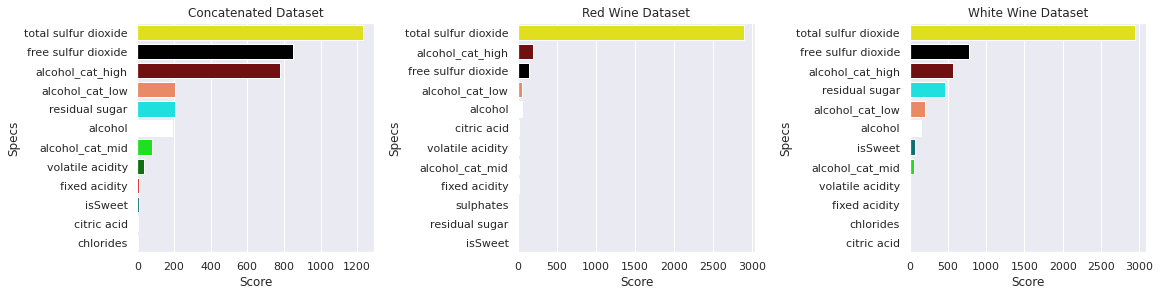

In [ ]:
# Colors for bars on chart corresponding with feature names
wine_palette ={'fixed acidity': 'red', 'volatile acidity': 'green', 
               'citric acid': 'blue', 'residual sugar': 'cyan', 
               'chlorides': 'orange', 'free sulfur dioxide': 'black', 
               'total sulfur dioxide': 'yellow', 'density': 'magenta', 
               'pH': 'purple', 'sulphates': 'grey', 'alcohol': 'white', 
               'quality': 'brown', 'isSweet': 'teal', 
               'alcohol_cat_high': 'maroon', 'alcohol_cat_low': 'coral', 
               'alcohol_cat_mid': 'lime'}

# Plot for feature importance
dims = (16, 4)
fig, ax = plt.subplots(1,3,figsize=dims, constrained_layout=True)

sns.barplot(x=fScores_concat['Score'],y=fScores_concat['Specs'], ax=ax[0],palette=wine_palette).set_title("Concatenated Dataset")
sns.barplot(x=fScores_red['Score'],y=fScores_red['Specs'], ax=ax[1],palette=wine_palette).set_title("Red Wine Dataset")
sns.barplot(x=fScores_white['Score'],y=fScores_white['Specs'], ax=ax[2],palette=wine_palette).set_title("White Wine Dataset")

## 4.6. Selected Feature Subset

In [ ]:
# Select all the feature subsets for each dataset that will be used in the model training.

ML_concat_df = corr_concat_df[['alcohol','alcohol_cat_high','density','volatile acidity','chlorides','alcohol_cat_low','alcohol_cat_mid','quality','total sulfur dioxide','residual sugar']]
ML_red_df = corr_red_df[['total sulfur dioxide','alcohol_cat_high','free sulfur dioxide','alcohol_cat_low','alcohol','citric acid','quality','residual sugar']]
ML_white_df = corr_white_df[['alcohol','alcohol_cat_high','density','chlorides','volatile acidity','alcohol_cat_low','total sulfur dioxide','quality','alcohol_cat_mid']]

## 4.7. Feature Scalling to remove noise from machine learning process and reduce overfitting.

In [ ]:
# Create the scalers
concat_scaler = MinMaxScaler(feature_range=(0,1))
red_scaler = MinMaxScaler(feature_range=(0,1))
white_scaler = MinMaxScaler(feature_range=(0,1))

# Scale the concatenated data set X values
concat_X_ready_unscalled = ML_concat_df.drop('quality',axis=1)
concat_X_ready = pd.DataFrame(concat_scaler.fit_transform(concat_X_ready_unscalled),
                           index=concat_X_ready_unscalled.index,columns=concat_X_ready_unscalled.columns)
concat_y_ready = ML_concat_df['quality']

# Scale the red wine dataset X values
red_X_ready_unscalled = ML_red_df.drop('quality',axis=1)
red_X_ready = pd.DataFrame(red_scaler.fit_transform(red_X_ready_unscalled),
                           index=red_X_ready_unscalled.index,columns=red_X_ready_unscalled.columns)
red_y_ready = ML_red_df['quality']

# Scale the white wine dataset X values
white_X_ready_unscalled = ML_white_df.drop('quality',axis=1)
white_X_ready = pd.DataFrame(white_scaler.fit_transform(white_X_ready_unscalled),
                           index=white_X_ready_unscalled.index,columns=white_X_ready_unscalled.columns)
white_y_ready = ML_white_df['quality']

# **5. Testing and Training Data Preperation**

-  This section includes a few methods that upsample the datasets to balance the quality distribution and map different classes to the quality values to reduce the number of labels from the original dataset.

## 5.1. Upsampling the training datasets to improve accuracy of 'quality' as I described it as unblananced in section 2.4

In [ ]:
# Split the datasets into their relevent training and testing sets.

concat_X_needs_upsampling, concat_X_test, concat_y_needs_upsampling, concat_y_test_unmapped = train_test_split(concat_X_ready, concat_y_ready, train_size = 0.7, test_size = 0.3, random_state = 10)
red_X_needs_upsampling, red_X_test, red_y_needs_upsampling, red_y_test_unmapped = train_test_split(red_X_ready, red_y_ready, train_size = 0.7, test_size = 0.3, random_state = 10)
white_X_needs_upsampling, white_X_test, white_y_needs_upsampling, white_y_test_unmapped = train_test_split(white_X_ready, white_y_ready, train_size = 0.7, test_size = 0.3, random_state = 10)

# Upsample all the training data for each of the datasets using SMOTE

concat_X_train, concat_y_train_unmapped = SMOTE(k_neighbors=1).fit_resample(concat_X_needs_upsampling, concat_y_needs_upsampling)
red_X_train, red_y_train_unmapped = SMOTE(k_neighbors=1).fit_resample(red_X_needs_upsampling, red_y_needs_upsampling)
white_X_train, white_y_train_unmapped = SMOTE(k_neighbors=1).fit_resample(white_X_needs_upsampling, white_y_needs_upsampling)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

## 5.2. Mapping of quality values to a user selected number of classes



In [ ]:
mapping_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1}

# Optional 9 class multiclass setting (default is binary classification)
# mapping_dict = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

# Create regression training and testing information datasets (regression models only)
X_training_regression = {'concat':concat_X_train,'red':red_X_train,'white':white_X_train}
X_testing_regression = {'concat':concat_X_test,'red':red_X_test,'white':white_X_test}
y_training_regression = {'concat':concat_y_train_unmapped,'red':red_y_train_unmapped,'white':white_y_train_unmapped}
y_testing_regression = {'concat':concat_y_test_unmapped,'red':red_y_test_unmapped,'white':white_y_test_unmapped}

# Map all the datasets for the classification models
concat_y_train = (pd.Series(concat_y_train_unmapped).map(mapping_dict)).to_numpy()
concat_y_test = concat_y_test_unmapped.map(mapping_dict)

red_y_train = (pd.Series(red_y_train_unmapped).map(mapping_dict)).to_numpy()
red_y_test =red_y_test_unmapped.map(mapping_dict)

white_y_train = (pd.Series(white_y_train_unmapped).map(mapping_dict)).to_numpy()
white_y_test = white_y_test_unmapped.map(mapping_dict)

# Names of datasets
datasets = ['concat','red','white']

# Create classification training and testing information datasets (classification models only)
X_training_classification = {'concat':concat_X_train,'red':red_X_train,'white':white_X_train}
X_testing_classification = {'concat':concat_X_test,'red':red_X_test,'white':white_X_test}
y_training_classification = {'concat':concat_y_train,'red':red_y_train,'white':white_y_train}
y_testing_classification = {'concat':concat_y_test,'red':red_y_test,'white':white_y_test}

# **6. Classification Machine Learning Stage**

## 6.1 Code for ROC 

In [ ]:
def build_ROC_curve(model, X_test, y_test, ds):

  # Check if model is a decision function or not
  # This is because it will need to plot different probabilities
    
    if hasattr(model, "decision_function"):
        probabilities = model.decision_function(X_test)
    else:
        probabilities = model.predict_proba(X_test)
        probabilities = probabilities[:,1]

    # Calculate false positive rate and true positive rate and create curve

    fpr, tpr, thr = roc_curve(y_test, probabilities)

    # Calculate area under curve
    roc_auc = auc(fpr, tpr)

    # Create figure and show
    fig = plt.figure()
    plt.title('{} ROC curve'.format(ds.capitalize()))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## 6.2. Hyper Parameter Tuning for Logistic Regression (Optional & Currently Commented out)

- This cell is commented out as it takes a long time to compute and the rest of the program is not dependent on it.

In [ ]:
# # Set the parameters
# tuned_parameters = [{'C': [1, 10, 100]}]

# for ds in datasets:

#   print("{} Dataset Hyper Parameter Tuning Report".format(ds.capitalize()))
#   print('--------------------------------------------------------------')

#   # Make a grid search model
#   clf = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), tuned_parameters, cv=5)

#   # Train grid search model
#   clf.fit(X_training_classification.get(ds), y_training_classification.get(ds))

#   # Report results
#   print("Best parameters set found on development set:\n")
#   print(clf.best_params_)
#   print("\nGrid scores on development set:\n")

#   means = clf.cv_results_['mean_test_score']
#   stds = clf.cv_results_['std_test_score']
#   for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#       print(f"{mean:.3f} (± {std * 2:.03f}) for {params}")

#   print('--------------------------------------------------------------')
#   print()
#   print()

## 6.3. Logistic Regression Example

Concat Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      7696
           1       0.77      0.74      0.76      5772

    accuracy                           0.80     13468
   macro avg       0.79      0.79      0.79     13468
weighted avg       0.80      0.80      0.80     13468

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1470
           1       0.45      0.60      0.51       376

    accuracy                           0.77      1846
   macro avg       0.67      0.70      0.68      1846
weighted avg       0.80      0.77      0.78      1846

Cross-validation scores: 0.79 (± 0.23)


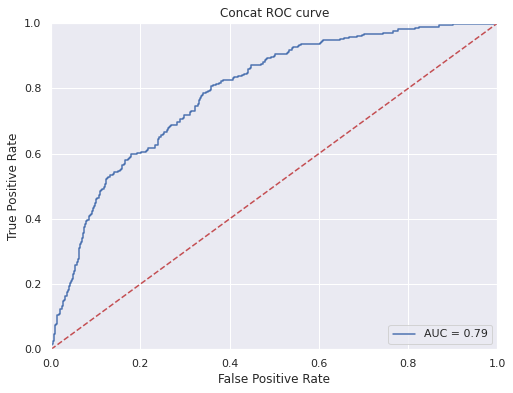


--------------------------------------------------------------

Red Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1752
           1       0.83      0.85      0.84       876

    accuracy                           0.89      2628
   macro avg       0.88      0.88      0.88      2628
weighted avg       0.89      0.89      0.89      2628

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       390
           1       0.42      0.75      0.53        59

    accuracy                           0.83       449
   macro avg       0.69      0.79      0.71       449
weighted avg       0.89      0.83      0.85       449

Cross-validation scores: 0.89 (± 0.20)


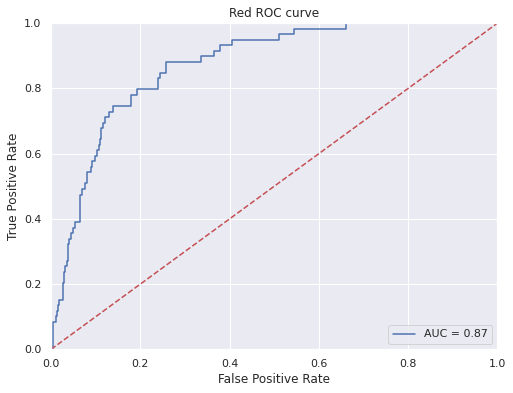


--------------------------------------------------------------

White Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      5808
           1       0.85      0.71      0.77      4356

    accuracy                           0.82     10164
   macro avg       0.83      0.81      0.81     10164
weighted avg       0.83      0.82      0.82     10164

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1090
           1       0.47      0.52      0.49       308

    accuracy                           0.76      1398
   macro avg       0.66      0.68      0.67      1398
weighted avg       0.77      0.76      0.77      1398

Cross-validation scores: 0.82 (± 0.22)


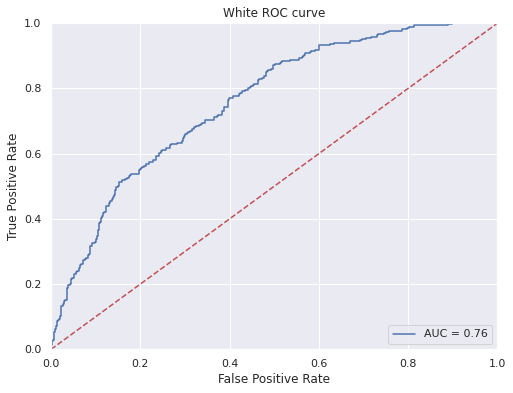


--------------------------------------------------------------



In [ ]:
concat_logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=10 )
red_logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=1 )
white_logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=1 )

# Create dictionary of all Logistic Regression models
logreg_dict = {'concat':concat_logreg, 'red':red_logreg, 'white':white_logreg}

for ds in datasets:

  # Select relevent model to dataset
  logreg = logreg_dict.get(ds)

  # Retrieve relevent training data
  X_train = X_training_classification.get(ds)
  y_train = y_training_classification.get(ds)
  X_test = X_testing_classification.get(ds)
  y_test = y_testing_classification.get(ds)

  # Fit the model
  logreg.fit(X_train,y_train)

  # Report the results
  print("{} Dataset Machine Learning Report".format(ds.capitalize()))
  print('--------------------------------------------------------------')
  y_pred_Train = logreg.predict(X_train)
  y_pred_Test = logreg.predict(X_test)

  print('Train Set Predictions Report:\n')
  print(classification_report(y_train, y_pred_Train))
  print('Test Set Predictions Report:\n')
  print(classification_report(y_test, y_pred_Test))

  scores = cross_val_score(logreg, X_train, y_train, cv=10)
  print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

  # Plot the ROC
  build_ROC_curve(logreg,X_test,y_test,ds)
  print()
  print('--------------------------------------------------------------')
  print()


## 6.4. Hyper Parameter Tuning for Random Forrests (Optional & Currently Commented out)

- This cell is commented out as it takes a long time to compute and the rest of the program is not dependent on it.

In [ ]:
# # Create ranges for hyper parameters
# max_features_range = np.arange(1,6,1)
# n_estimators_range = np.arange(10,210,10)

# # Add parameters to a dictionary
# param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range)

# # Train each dataset model
# for ds in datasets:

#   # Get relevant training data
#   X_train = X_training_classification.get(ds)
#   y_train = y_training_classification.get(ds)

#   rf = RandomForestClassifier()

#   # Make a grid search model
#   grid = GridSearchCV(estimator=rf, param_grid=param_grid,cv = 5)

#   # Train grid search model
#   grid.fit(X_train,y_train)

#   # Report results
#   print("{} Random Forrest Hyper Parameter Tuning Report".format(ds.capitalize()))
#   print('--------------------------------------------------------------')
#   print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
#   print('--------------------------------------------------------------')
#   print()

## 6.5. Random Forests Example

Concat Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7696
           1       1.00      1.00      1.00      5772

    accuracy                           1.00     13468
   macro avg       1.00      1.00      1.00     13468
weighted avg       1.00      1.00      1.00     13468

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1470
           1       0.72      0.56      0.63       376

    accuracy                           0.87      1846
   macro avg       0.81      0.75      0.77      1846
weighted avg       0.86      0.87      0.86      1846

Cross-validation scores: 0.96 (± 0.10)


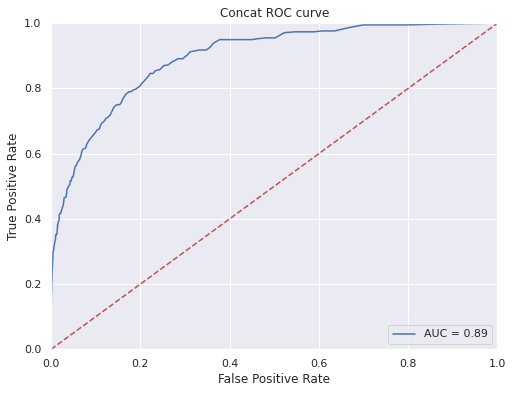


--------------------------------------------------------------

Red Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       876

    accuracy                           1.00      2628
   macro avg       1.00      1.00      1.00      2628
weighted avg       1.00      1.00      1.00      2628

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       390
           1       0.62      0.59      0.61        59

    accuracy                           0.90       449
   macro avg       0.78      0.77      0.78       449
weighted avg       0.90      0.90      0.90       449

Cross-validation scores: 0.96 (± 0.11)


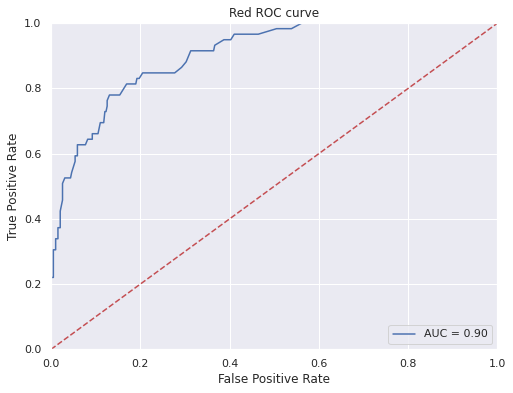


--------------------------------------------------------------

White Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5808
           1       1.00      1.00      1.00      4356

    accuracy                           1.00     10164
   macro avg       1.00      1.00      1.00     10164
weighted avg       1.00      1.00      1.00     10164

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1090
           1       0.65      0.61      0.63       308

    accuracy                           0.84      1398
   macro avg       0.77      0.76      0.77      1398
weighted avg       0.84      0.84      0.84      1398

Cross-validation scores: 0.95 (± 0.11)


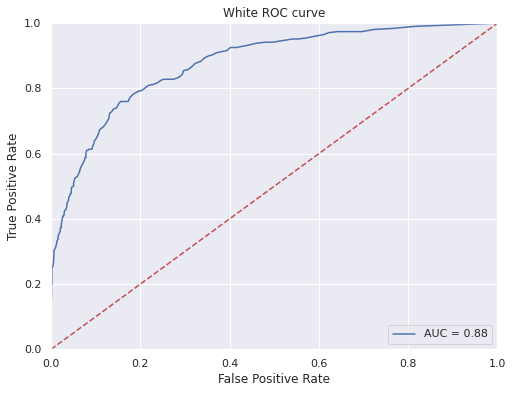


--------------------------------------------------------------



In [ ]:
concat_rf = RandomForestClassifier(max_features=1,n_estimators=150)
red_rf = RandomForestClassifier(max_features=1,n_estimators=160)
white_rf = RandomForestClassifier(max_features=2,n_estimators=150)

# Create dictionary of all Random Forest models
rf_dict = {'concat':concat_rf, 'red':red_rf, 'white':white_rf}

for ds in datasets:

  # Select relevent model to dataset
  rf = rf_dict.get(ds)

  # Retrieve relevent training data 
  X_train = X_training_classification.get(ds)
  y_train = y_training_classification.get(ds)
  X_test = X_testing_classification.get(ds)
  y_test = y_testing_classification.get(ds)

  # Fit the model
  rf.fit(X_train,y_train)

  # Report the results
  print("{} Dataset Machine Learning Report".format(ds.capitalize()))
  print('--------------------------------------------------------------')
  y_pred_Train = rf.predict(X_train)
  y_pred_Test = rf.predict(X_test)

  print('Train Set Predictions Report:\n')
  print(classification_report(y_train, y_pred_Train))
  print('Test Set Predictions Report:\n')
  print(classification_report(y_test, y_pred_Test))

  scores = cross_val_score(rf, X_train, y_train, cv=10)
  print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

  # Plot the ROC
  build_ROC_curve(rf,X_test,y_test,ds)
  print()
  print('--------------------------------------------------------------')
  print()

## 6.6. KNN Hyper Parameter Tuning (Optional & Currently Commented out)

- This cell is commented out as it takes a long time to compute and the rest of the program is not dependent on it.

In [ ]:
# for ds in datasets:

#   print("{} Dataset Hyper Parameter Tuning Report".format(ds.capitalize()))
#   print('--------------------------------------------------------------')

#   # Range of n_neighbords to test
#   n_neighbors = list(range(1,30))
  
#   # Convert this to a dict
#   hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#   #Create  KNN object
#   knn = KNeighborsClassifier()
#   # Build GridSearch model
#   clf = GridSearchCV(knn, hyperparameters, cv=10)
#   # Fit model
#   best_model = clf.fit(X_training.get(ds),y_training.get(ds))
#   # Print the best n_neighbors value
#   print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

#   print('--------------------------------------------------------------')
#   print()
#   print()

## 6.7. KNN Example


Concat Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7696
           1       1.00      1.00      1.00      5772

    accuracy                           1.00     13468
   macro avg       1.00      1.00      1.00     13468
weighted avg       1.00      1.00      1.00     13468

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1470
           1       0.57      0.56      0.57       376

    accuracy                           0.83      1846
   macro avg       0.73      0.73      0.73      1846
weighted avg       0.82      0.83      0.82      1846

Cross-validation scores: 0.96 (± 0.08)


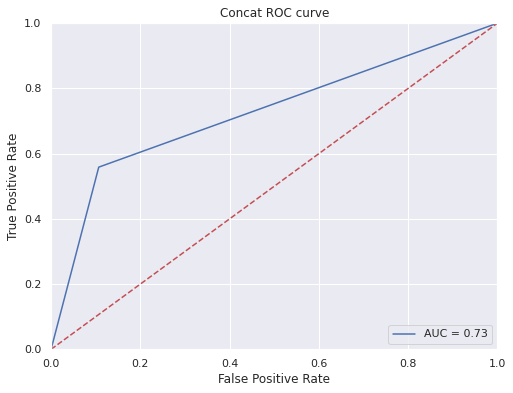


--------------------------------------------------------------

Red Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       876

    accuracy                           1.00      2628
   macro avg       1.00      1.00      1.00      2628
weighted avg       1.00      1.00      1.00      2628

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       390
           1       0.44      0.54      0.49        59

    accuracy                           0.85       449
   macro avg       0.69      0.72      0.70       449
weighted avg       0.86      0.85      0.86       449

Cross-validation scores: 0.97 (± 0.07)


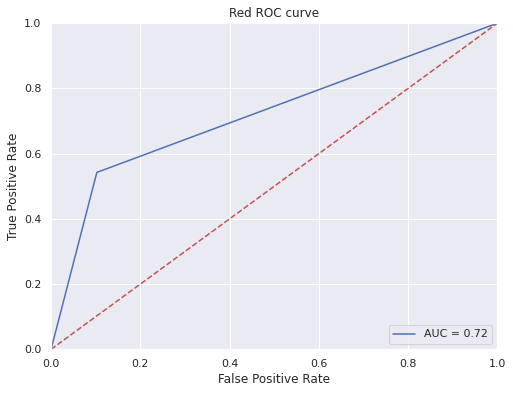


--------------------------------------------------------------

White Dataset Machine Learning Report
--------------------------------------------------------------
Train Set Predictions Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5808
           1       1.00      1.00      1.00      4356

    accuracy                           1.00     10164
   macro avg       1.00      1.00      1.00     10164
weighted avg       1.00      1.00      1.00     10164

Test Set Predictions Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1090
           1       0.56      0.64      0.60       308

    accuracy                           0.81      1398
   macro avg       0.73      0.75      0.74      1398
weighted avg       0.82      0.81      0.82      1398

Cross-validation scores: 0.96 (± 0.09)


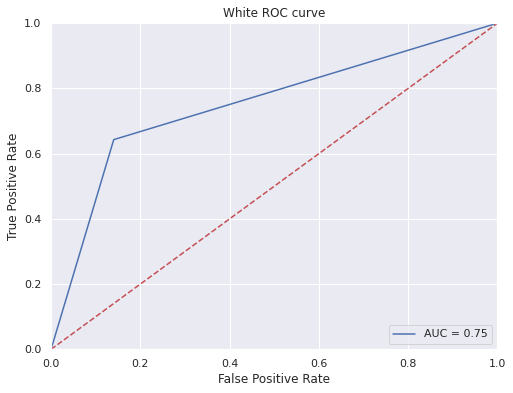


--------------------------------------------------------------



In [ ]:
concat_knn = KNeighborsClassifier(n_neighbors=1)
red_knn = KNeighborsClassifier(n_neighbors=1)
white_knn = KNeighborsClassifier(n_neighbors=1)

# Create dictionary of all KNN models
knn_dict = {'concat':concat_knn, 'red':red_knn, 'white':white_knn}

for ds in datasets:

  # Select relevent model to dataset
  knn = knn_dict.get(ds)

  # Retrieve relevent training data
  X_train = X_training_classification.get(ds)
  y_train = y_training_classification.get(ds)
  X_test = X_testing_classification.get(ds)
  y_test = y_testing_classification.get(ds)

  # Fit the model
  knn.fit(X_train,y_train)

  # Report the results
  print("{} Dataset Machine Learning Report".format(ds.capitalize()))
  print('--------------------------------------------------------------')
  y_pred_Train = knn.predict(X_train)
  y_pred_Test = knn.predict(X_test)

  print('Train Set Predictions Report:\n')
  print(classification_report(y_train, y_pred_Train))
  print('Test Set Predictions Report:\n')
  print(classification_report(y_test, y_pred_Test))

  scores = cross_val_score(knn, X_train, y_train, cv=10)
  print(f"Cross-validation scores: {scores.mean():.2f} (± {scores.std() * 2:.2f})")

  # Plot the ROC
  build_ROC_curve(knn,X_test,y_test,ds)
  print()
  print('--------------------------------------------------------------')
  print()

# **7. Regression Machine Learning Stage**

## 7.1. Linear Regression Example

In [ ]:
concat_lnr = LinearRegression(fit_intercept=True)
red_lnr = LinearRegression(fit_intercept=True)
white_lnr = LinearRegression(fit_intercept=True)

sc_y = StandardScaler()

# Create regression model dictionary
lnr_dict = {'concat':concat_lnr, 'red':red_lnr, 'white':white_lnr}

results = pd.DataFrame()

for ds in datasets:

  # Get the correct linear regression model for the dataset
  lnr = lnr_dict.get(ds)

  # Get relevent training and testing data for algorithm
  X_train = X_training_classification.get(ds)
  y_train = y_training_regression.get(ds)
  X_test = X_testing_classification.get(ds)
  y_test = y_testing_regression.get(ds)

  #Scale y data
  y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
  y_test = sc_y.fit_transform((y_test.to_numpy()).reshape(-1, 1))

  # Fit the algorithm
  lnr.fit(X_train,y_train)
  y_pred_train = lnr.predict(X_train) # Predict the X training data
  y_pred_test = lnr.predict(X_test) # Predict the X testing data


  print("{} Dataset Machine Learning Report".format(ds.capitalize()))
  print('--------------------------------------------------------------')
  # Accuracy on training data
  print("Training Data Accuracy:",lnr.score(X_train, y_train))

  # Accuracy on testing data
  print()
  print("Testing Data Accuracy:",lnr.score(X_test, y_test))

  print()
  # Calculate the Root Mean Squared Error
  print("RMSE on the training data:",sqrt(mean_squared_error(y_train,y_pred_train)))
  print("RMSE on the testing data:",sqrt(mean_squared_error(y_test,y_pred_test)))


  print()
  # Calculate the Mean Absolute Error
  print("MAE on the training data:",mean_absolute_error(y_train,y_pred_train))
  print("MAE on the testing data:",mean_absolute_error(y_test,y_pred_test))

  print()
  print('--------------------------------------------------------------')
  print()

  # Store results in a temporary dataframe and add it to the existing results dataframe.

  temp_pd = pd.DataFrame()

  predictions = lnr.predict(X_test)
  predictions = sc_y.inverse_transform(predictions)

  actuals = y_test
  actuals = sc_y.inverse_transform(actuals)

  temp_pd[('Results')] = predictions.reshape(-1)
  temp_pd['Dataset Type'] = ds.capitalize()
  temp_pd[('Actuals')] = actuals.reshape(-1)

  results = pd.concat([results,temp_pd])



Concat Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.45881985555001026

Testing Data Accuracy: 0.16212519768477396

RMSE on the training data: 0.735649471181751
RMSE on the testing data: 0.915355014360672

MAE on the training data: 0.6014614575405591
MAE on the testing data: 0.7207383498565559

--------------------------------------------------------------

Red Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.5747425801695739

Testing Data Accuracy: 0.15708591981667286

RMSE on the training data: 0.6521176426308569
RMSE on the testing data: 0.9181035236743877

MAE on the training data: 0.5472405914811499
MAE on the testing data: 0.7325100342168881

--------------------------------------------------------------

White Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.58515

Plot of Results

Text(0.44, 0.98, 'Linear Regression Scatter Plot, comparing actuals to results')

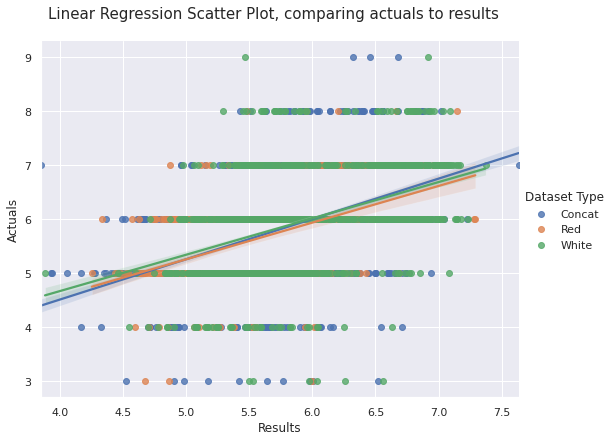

In [ ]:
#Plot results from Linear Regression algorithm as a lm/scatter plot, showing regression line.

g = sns.lmplot(data=results,x='Results',y='Actuals',hue='Dataset Type',height=6,aspect=1.2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Linear Regression Scatter Plot, comparing actuals to results",
                  fontsize=15, fontdict={"weight": "bold"},x=0.44)

## 7.2. Support Vector Regression (SRV)

In [ ]:
concat_regressor = SVR(kernel = 'rbf')
red_regressor = SVR(kernel = 'rbf')
white_regressor = SVR(kernel = 'rbf')

y_scaler = StandardScaler()

# Create regression model dictionary
regressor_dict = {'concat':concat_regressor, 'red':red_regressor, 'white':white_regressor}

for ds in datasets:

  # Get the correct regressor for the dataset
  regressor = regressor_dict.get(ds)

  # Get relevent training and testing data for algorithm

  X_train = X_training_classification.get(ds)
  y_train = y_training_regression.get(ds)
  X_test = X_testing_classification.get(ds)
  y_test = y_testing_regression.get(ds)

  #Scale y data
  y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
  y_test = y_scaler.fit_transform((y_test.to_numpy()).reshape(-1, 1))

  regressor.fit(X_train,y_train) # Fit the algorithm
  y_pred_train = regressor.predict(X_train) # Predict the X training data
  y_pred_test = regressor.predict(X_test) # Predict the X testing data


  print("{} Dataset Machine Learning Report".format(ds.capitalize()))
  print('--------------------------------------------------------------')
  # Accuracy on training data
  print("Training Data Accuracy:",regressor.score(X_train, y_train))

  # Accuracy on testing data
  print()
  print("Testing Data Accuracy:",regressor.score(X_test, y_test))

  print()
  # Calculate the Root Mean Squared Error
  print("RMSE on the training data:",sqrt(mean_squared_error(y_train,y_pred_train)))
  print("RMSE on the testing data:",sqrt(mean_squared_error(y_test,y_pred_test)))


  print()
  # Calculate the Mean Absolute Error
  print("MEA on the training data:",mean_absolute_error(y_train,y_pred_train))
  print("MEA on the testing data:",mean_absolute_error(y_test,y_pred_test))

  print()
  print('--------------------------------------------------------------')
  print()

  # Store results in a temporary dataframe and add it to the existing results dataframe.

  temp_pd = pd.DataFrame()

  predictions = regressor.predict(X_test)
  predictions = y_scaler.inverse_transform(predictions) # Unscale Predictions

  actuals = y_test
  actuals = y_scaler.inverse_transform(actuals) # Unscale Actuals

  temp_pd[('Results')] = predictions.reshape(-1)
  temp_pd['Dataset Type'] = ds.capitalize()
  temp_pd[('Actuals')] = actuals.reshape(-1)

  results = pd.concat([results,temp_pd])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Concat Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.7410554157155642

Testing Data Accuracy: 0.19883428874937323

RMSE on the training data: 0.5088659787060201
RMSE on the testing data: 0.8950786061853042

MEA on the training data: 0.3628363360763208
MEA on the testing data: 0.7015234732658343

--------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Red Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.7300773608368343

Testing Data Accuracy: 0.07884550173407456

RMSE on the training data: 0.5195407964377444
RMSE on the testing data: 0.9597679397989524

MEA on the training data: 0.349521306243844
MEA on the testing data: 0.7680689744710422

--------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


White Dataset Machine Learning Report
--------------------------------------------------------------
Training Data Accuracy: 0.7357893315670694

Testing Data Accuracy: 0.16845337285437811

RMSE on the training data: 0.5140142687055784
RMSE on the testing data: 0.9118917847780086

MEA on the training data: 0.3626701835757787
MEA on the testing data: 0.702002820234849

--------------------------------------------------------------



Text(0.44, 0.98, 'Support Vector Regressor Scatter Plot, comparing actuals to results')

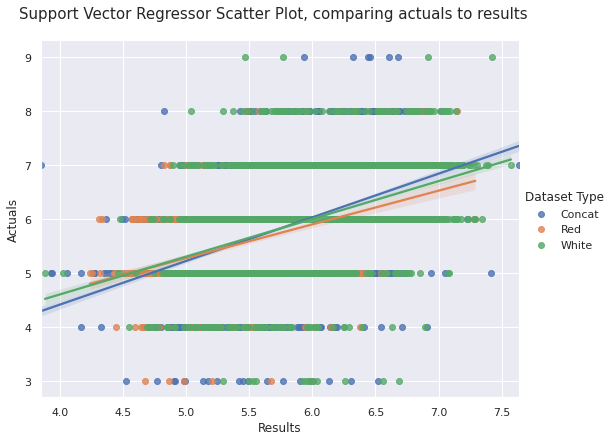

In [ ]:
#Plot results from SVR algorithm as a lm/scatter plot, showing regression line.

g = sns.lmplot(data=results,x='Results',y='Actuals',hue='Dataset Type',height=6,aspect=1.2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Support Vector Regressor Scatter Plot, comparing actuals to results",
                  fontsize=15, fontdict={"weight": "bold"},x=0.44)

# **8. Data Format Tool**

- Used to convert data into a machine learning format when a user wants to predict on their own wine datasets to find out the quality.

In [ ]:
def data_formater(frame_to_format):
  
  # Copy of the alcohol cat code from section 3.1
  # This code maps 'alcohol' to a 3 label multiclass

  new_df = frame_to_format
  data_struct = frame_to_format[numerical].describe()
  alc_mean = data_struct['alcohol']['mean']
  alc_stddev = data_struct['alcohol']['std']
  new_df['alcohol_cat'] = ''

  for record in new_df.index:
    x = new_df['alcohol'][record]
    if (x < alc_mean - alc_stddev):
      new_df['alcohol_cat'][record] = 'low'
    elif (x > alc_mean + alc_stddev):
      new_df['alcohol_cat'][record] = 'high'
    else:
      new_df['alcohol_cat'][record] = 'mid'

  # Turn multiclass into binary classifying features

  all_feat = pd.get_dummies(new_df, columns=['alcohol_cat'])

  # Filter out only the important features

  important_feat = all_feat[['alcohol','alcohol_cat_high','density',
                             'volatile acidity','chlorides','alcohol_cat_low',
                             'alcohol_cat_mid','quality','total sulfur dioxide',
                             'residual sugar']]

  # Scale the X data for better training
  X_ready_unscalled = important_feat.drop('quality',axis=1)
  X_ready = pd.DataFrame(concat_scaler.fit_transform(X_ready_unscalled),
                            index=X_ready_unscalled.index,columns=X_ready_unscalled.columns)
  y_ready_unmapped = important_feat['quality']

  # Map the target class to turn it into a binary classifier
  mapping_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1}
  y_ready = y_ready_unmapped.map(mapping_dict)

  return X_ready, y_ready # Return X (features) and y (target)




# **9. Conclusion and Final Model Artefact Tool**

- The most successful model was **Random Forests**, trained using best using the **concatenated dataset**. It achieved a **cross-validation score of 0.96** and in light of this evidence, it should accurately predict if a wine is of good or bad quality. The high cross-validation score suggests that there is very little overfitting and suggests the model should work well on different wine datasets for quality prediction.

In [ ]:
final_model = rf_dict.get('concat') #Recieving concatenated Random Forrest Model
X_train = X_training_classification.get('concat') #Recieving concatenated training data
y_train = y_training_classification.get('concat') 


final_model.fit(X_train,y_train) # Fitting the model using concatenated wine dataset.

data_to_test = pd.read_csv('new_data.csv',header=0, delimiter=";") # Change the string 'new_data.csv' to your wine dataset.

X, y = data_formater(data_to_test) # Function will return formatted X and y values

predictions = final_model.predict(X) # Predictions made on X values

print(classification_report(y, predictions)) # Report on predictions






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3838
           1       0.58      0.17      0.27      1060

    accuracy                           0.79      4898
   macro avg       0.69      0.57      0.57      4898
weighted avg       0.76      0.79      0.75      4898

